# Simple Bayes Classifier

P(x|w1) = N(5,2)<br/>
P(x|w2) = N(0,2)

In [0]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats

def plot_normal(avg, var, prior=0.5, label=None):
  sigma = math.sqrt(var)
  x = np.linspace(avg - 3*sigma, avg + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, avg, sigma) * prior, label=label)
  
def draw_boundary(x):
  plt.axvline(x = x, linestyle = '--', c = 'r', label='x = %.2f' % x)

# T2
plot_normal(5, 2, label='Happy cat')
plot_normal(0, 2, label='Sad cat')
draw_boundary(2.5)
plt.legend()
plt.show()

In [0]:
# T3
plot_normal(5, 2, label='Happy cat', prior=0.8)
plot_normal(0, 2, label='Sad cat', prior=0.2)
draw_boundary(1.9455)
plt.legend()
plt.show()

In [0]:
# OT2.2
plot_normal(5, 2, label='Happy cat')
plot_normal(0, 4, label='Sad cat')
draw_boundary(2.7355)
plt.legend()
plt.show()

# Employee Attrition Prediction

Firstly, load the dataset, convert the yes and no in this data table to 1 and 0. Then, we have to convert each categorical feature to number.

In [0]:
import pandas as pd
data_url = "https://raw.github.com/ekapolc/pattern_2019/master/HW/HW2/hr-employee-attrition-with-null.csv"
all = pd.read_csv(data_url)

cat_cols = ('BusinessTravel', 'Department', 'EducationField', 
            'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime')

all.loc[all["Attrition"] == "No", "Attrition"] = 0.0
all.loc[all["Attrition"] == "Yes", "Attrition"] = 1.0
for col in cat_cols:
  all[col] = pd.Categorical(all[col]).codes # NaN will be converted to -1!
all = all.drop(columns = "EmployeeNumber")

We'll split the dataset to 90% `train_set` and 10% `test_set`

In [0]:
TESTSET_RATIO = 0.1

def default_split_data(): 
  no_attr_size = len(all[all['Attrition'] == 0].index)
  yes_attr_size = len(all[all['Attrition'] == 1].index)
  test_size_no = int(TESTSET_RATIO * no_attr_size)
  test_size_yes =  int(TESTSET_RATIO * yes_attr_size)

  test_no = all[all['Attrition'] == 0].tail(test_size_no)
  test_yes = all[all['Attrition'] == 1].tail(test_size_yes)
  train_no = all[all['Attrition'] == 0].head(no_attr_size - test_size_no)
  train_yes = all[all['Attrition'] == 1].head(yes_attr_size - test_size_yes)

  test_set = pd.concat((test_no, test_yes))
  train_set = pd.concat((train_no, train_yes))
  return train_set, test_set

train_set, test_set = default_split_data()

## Histogram discretization

To do histogram estimation, we divide the entire data space into a finite number of bins. Then, we count how many data points are there in each bin and normalize using the total number of data points (so that the probability sums to 1).

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(col, BIN_COUNT = 40, count_zbin = True):
  # remove NaN values
  train_col_no_nan = train_set[~np.isnan(train_set[col])][col]

  '''
    bin the data into 40 equally spaced bins
    hist is the count for each bin
    bin_edge is the edge values of the bins
  '''
  
  hist, bin_edge = np.histogram(train_col_no_nan, BIN_COUNT)

  # plot the histogram 
  plt.fill_between(bin_edge.repeat(2)[1:-1],hist.repeat(2),facecolor='steelblue')
  plt.show()
  
  if count_zbin:
    print('Number of bins with zero count:', len(list(filter(lambda e: e == 0, hist))))

# T4
plot_hist('Age')
plot_hist('MonthlyIncome')
plot_hist('DistanceFromHome')

In [0]:
def build_hist(train_set, col, BIN_COUNT = 10, condition = {}, plt = None):
  train_col_no_nan = np.array(train_set[~np.isnan(train_set[col]) & np.not_equal(train_set[col], -1)][col])
  if condition:
    if 'given' in condition:
      given_col, col_cond = condition['given']
      filtered_train_set = train_set[train_set[given_col] == col_cond]
      train_col_no_nan = np.array(train_set[np.equal(train_set[given_col], col_cond) & ~np.isnan(train_set[col]) & np.not_equal(train_set[col], -1)][col])
  
  hist, bins = np.histogram(train_col_no_nan, BIN_COUNT)
  idx = np.digitize(train_col_no_nan, [float('-inf')] + list(bins[1:-1]) + [float('inf')])
  # print(np.bincount(idx))
  if plt:
    try:
      condition_text = "%s=%d" % (given_col, col_cond) 
    except:
      condition_text = ''
    if hasattr(plt.title, 'set_text'):
      plt.title.set_text("%s, %d bins, %s" % (col, BIN_COUNT, condition_text))
    else:
      plt.title("%s, %d bins, %s" % (col, BIN_COUNT, condition_text))
    plt.hist(train_col_no_nan, bins)
  
  bins[0], bins[-1] = float('-inf'), float('inf')
  return (bins, np.bincount(idx))

def show_hist_col_bin(features, bin_count, figsize = [12, 7], hspace = 0.5):
  fig, ax = plt.subplots(nrows=len(features), ncols=len(bin_count), figsize=figsize)
  fig.subplots_adjust(hspace = hspace)
  for i in range(len(features)):
    for j in range(len(bin_count)):
      build_hist(train_set, features[i], bin_count[j], plt=ax[i][j])

  plt.show()

# T6
features = ['Age', 'MonthlyIncome', 'DistanceFromHome']
bin_count = [10, 40, 100]
show_hist_col_bin(features, bin_count)


In [0]:
# T7
features = ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole'] #train_set.columns
bin_count = [10, 40]
show_hist_col_bin(features, bin_count, [16, 20], 0.8)

In [0]:
# T8
features = ['MonthlyIncome', 'JobRole', 'HourlyRate', 'MaritalStatus']
fig, ax = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 7,))
fig.subplots_adjust(hspace = 0.7)
for i in range(len(features)):
  for j in range(2):
    build_hist(train_set, features[i], 10, {'given': ('Attrition', j)}, ax[i][j])

plt.show()

In [0]:
# T9
prior_stay = train_set[train_set['Attrition'] == 0].shape[0] / train_set.shape[0]
prior_leave =  train_set[train_set['Attrition'] == 1].shape[0] / train_set.shape[0]
print('P(stay) =', prior_stay)
print('P(leave) =', prior_leave)

P(stay) = 0.8383685800604229
P(leave) = 0.16163141993957703


Building the learned distribution.

In [0]:
from functools import reduce

def train_discrete_model(features, bin_count = 10, train_set = None):
  if train_set is not pd.DataFrame:
    train_set = default_split_data()[0]
  return reduce(lambda ac, feature: 
             ac.update({ 
                 (feature, 0): build_hist(train_set, feature, bin_count, {'given': ('Attrition', 0) }),
                 (feature, 1): build_hist(train_set, feature, bin_count, {'given': ('Attrition', 1) })
             }) or ac, features, {})

model = train_discrete_model(['Age', 'MonthlyIncome', 'DistanceFromHome'])

Build a naive bayes classifier

In [0]:
from math import log

def find_bin_prob(data, feature, attrition, model):
  bins, bin_count = model[(feature, attrition)]
  if np.isnan(data[feature]):
    return 1
  prob = bin_count[np.digitize(data[feature], bins)] / sum(bin_count)
  return prob if prob > 0 else 1

def discrete_classify(data, features, model):
  s = 0
  for feature in features:
    s += log(find_bin_prob(data, feature, 1, model)) - log(find_bin_prob(data, feature, 0, model))
  return log(prior_leave) - log(prior_stay) + s

discrete_classify({ 'Age': 22.1 }, ['Age'], model)

-0.25435236704291864

Test the model and report precision, recall and F score.

In [0]:
def test_result(result, showTable = True):
  try:
    precision = result[1][1] / (result[1][1] + result[0][1])
  except ZeroDivisionError:
    precision = float('inf')
  recall = result[1][1] / (result[1][1] + result[1][0])
  try:
    fscore = 2 * precision * recall / (precision + recall)
  except ZeroDivisionError:
    fscore = float('nan')
  falseAlarm = result[0][1] / (result[0][1] + result[0][0])
  
  if showTable:
    print('             +--------------+-------------+')
    print('             | Detected Yes | Detected No |')
    print('+------------+--------------+-------------+')
    print('| Actual Yes |    %4d      |    %4d     |' % (result[1][1], result[1][0]))
    print('+------------+--------------+-------------+')
    print('| Actual No  |    %4d      |    %4d     |' % (result[0][1], result[0][0]))
    print('+------------+--------------+-------------+')

    print('Precision =', precision)
    print('Recall =', recall)
    print('F Score =', fscore)
    print()
  
  return { 'precision': precision, 'recall': recall, 'fscore': fscore, 'falseAlarm': falseAlarm }

'''
Classifier must contain 3 param: data, features and the model
'''
def test_model(classifier, test_set, features = None, model = None, showResult = True, threshold = 0):
  tests = test_set.to_dict(orient='records')
  result = [[0, 0], [0, 0]]

  for test in tests:
    detected = classifier(test, features, model)
    actual = test['Attrition']
    result[actual][int(detected > threshold)] += 1

  return test_result(result, showResult)

features = ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole']
model = train_discrete_model(features)
test_model(discrete_classify, test_set, features, model)

## Probability Density Funciton

In [0]:
# T12
import scipy.stats as stats

def find_pdf_arg(train_set, col, attrition):
  train_col_no_nan = np.array(train_set[np.equal(train_set['Attrition'], attrition) & ~np.isnan(train_set[col]) & np.not_equal(train_set[col], -1)][col])
  return np.mean(train_col_no_nan), np.std(train_col_no_nan)

def find_pdf_prob(data, feature, attrition, model):
  avg, std = model[(feature, attrition)]
  if np.isnan(data[feature]):
    return 1
  return stats.norm(avg, std).pdf(data[feature])
  
def train_pdf_model(features):
    return reduce(lambda ac, feature: 
             ac.update({ 
                 (feature, 0): find_pdf_arg(train_set, feature, 0),
                 (feature, 1): find_pdf_arg(train_set, feature, 1)
             }) or ac, features, {})
  
def pdf_classify(data, feature, model):
  s = 0
  for feature in features:
    s += log(find_pdf_prob(data, feature, 1, model)) - log(find_pdf_prob(data, feature, 0, model))
  return log(prior_leave) - log(prior_stay) + s
  

features = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole']
model = train_pdf_model(features)
test_model(pdf_classify, test_set, features, model)

## Baseline Comparison

The random choice baseline

In [0]:
# T13
import random
def random_baseline(test, feature, model):
  return [float('-inf'), float('inf')][random.randint(0, 1)]

test_model(random_baseline, test_set)

The majority rule baseline

In [0]:
# T14
MAJORITY_CLASS = 0
def majority_rule(test, feature, model):
  return [float('-inf'), float('inf')][MAJORITY_CLASS]

test_model(majority_rule, test_set)

## Threshold Finding

100% (200 of 200) |######################| Elapsed Time: 0:03:27 Time:  0:03:27


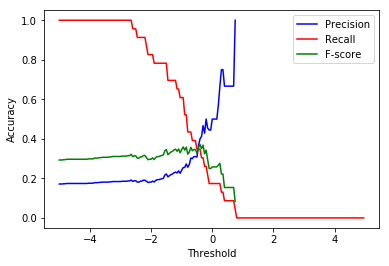

(0.37209302325581395, -0.40000000000001634, {'precision': 0.4, 'recall': 0.34782608695652173, 'fscore': 0.37209302325581395, 'falseAlarm': 0.0975609756097561})


In [0]:
from progressbar import progressbar
THRESHOLD_RANGE = np.arange(-5, 5, 0.05)

features = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole']
model = train_pdf_model(features)
classifier = pdf_classify
precision = []
recall = []
fscore = []
bestScore = (-1, 0, {})
for t in progressbar(THRESHOLD_RANGE):
  score = test_model(classifier, test_set, features, model, showResult = False, threshold = t)
  precision.append(score['precision'])
  recall.append(score['recall'])
  fscore.append(score['fscore'])
  bestScore = max(bestScore, (score['fscore'], t, score))
plt.plot(THRESHOLD_RANGE, precision, c='b', label='Precision')
plt.plot(THRESHOLD_RANGE, recall, c='r', label='Recall')
plt.plot(THRESHOLD_RANGE, fscore, c='g', label='F-score')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(bestScore)

## RoC

N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing pdf


100% (200 of 200) |######################| Elapsed Time: 0:03:29 Time:  0:03:29
  3% (6 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05


Testing discrete_10


100% (200 of 200) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
  3% (6 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05


Testing discrete_5


100% (200 of 200) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


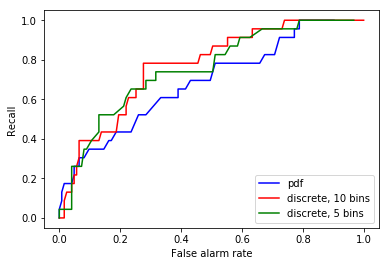

In [0]:
from progressbar import progressbar
THRESHOLD_RANGE = np.arange(-5, 5, 0.05)

features = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole']

properties = {
    'pdf': {
        'model': train_pdf_model(features),
        'label': 'pdf',
        'color': 'b',
        'classifier': pdf_classify
    },
    'discrete_10': {
        'model': train_discrete_model(features),
        'label': 'discrete, 10 bins',
        'color': 'r',
        'classifier': discrete_classify
    },
    'discrete_5': {
        'model': train_discrete_model(features, 5),
        'label': 'discrete, 5 bins',
        'color': 'g',
        'classifier': discrete_classify
    }
}

for model_name in properties:
  roc = []
  prop = properties[model_name]
  print('\nTesting', model_name)
  for t in progressbar(THRESHOLD_RANGE):
    score = test_model(prop['classifier'], test_set, features, prop['model'], showResult = False, threshold = t)
    roc.append((score['falseAlarm'], score['recall']))

  roc.sort()
  falseAlarm = [e[0] for e in roc]
  recall = [e[1] for e in roc]

  plt.plot(falseAlarm, recall, c=prop['color'], label=prop['label'])

plt.xlabel('False alarm rate')
plt.ylabel('Recall')
plt.legend()
plt.show()

## Classifier Variance

In [0]:
def shuffle_data():
  new_test_set = pd.concat((all[all['Attrition'] == 0].sample(frac=TESTSET_RATIO),
                           all[all['Attrition'] == 1].sample(frac=TESTSET_RATIO)))
  new_train_set =pd.concat([all,new_test_set]).drop_duplicates(keep=False)
  return new_train_set, new_test_set

features = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole']
classifier = discrete_classify
TEST_COUNT = 10
res = []
for i in progressbar(range(TEST_COUNT)):
  loc_train_set, loc_test_set = shuffle_data()
  model = train_discrete_model(features, train_set = loc_train_set)
  res.append(test_model(classifier, loc_test_set, features, model, False)['fscore'])
print(res)
print('F-score Mean =', np.mean(res))
print('F-score Variance =', np.var(res))


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


[0.19512195121951217, 0.24390243902439027, 0.2380952380952381, 0.3137254901960785, 0.2608695652173913, 0.3, 0.24489795918367346, 0.4583333333333333, 0.20408163265306126, 0.30434782608695654]
F-score Mean = 0.2763375435009635
F-score Variance = 0.0051423918674363845
